
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable

### Integrantes
- Bosch, Daniela
- Gherra, Estefanía
- Iberra, Yanina
- Mantovani, Luciano
- Palacio Pastor, Natalí

## Introducción

Esta notebook presenta el trabajo de aprendizaje supervisado realizado para la [competencia en Kaggle de la Diplomatura en Ciencia de Datos](https://www.kaggle.com/c/diplodatos-travel-insurance-prediction-data).

Esta competencia constituye el práctico de la materia Aprendizaje Supervisado de la edición 2021 de la Diplodatos. La misma está basada en los datos de la competencia [Travel Insurance Prediction Data de Kaggle](https://www.kaggle.com/tejashvi14/travel-insurance-prediction-data).

El objetivo es intentar predecir si un cliente estaría interesado en comprar un seguro de viaje.



In [ ]:
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from google.colab import files

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import classification_report

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Lectura del dataset

Obtenemos los datos de entrenamiento y los datos de test. Sobre el segundo conjunto se realizará la predicción final que será presentada en la plataforma Kaggle.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving travel_insurance_prediction_test.csv to travel_insurance_prediction_test (2).csv
Saving travel_insurance_prediction_train.csv to travel_insurance_prediction_train (2).csv
Saving travel_insurance_submission.csv to travel_insurance_submission (2).csv


In [ ]:
import io
train_df = pd.read_csv(
    io.StringIO(uploaded['travel_insurance_prediction_train.csv'].decode('utf-8')),
)
test_df = pd.read_csv(
    io.StringIO(uploaded['travel_insurance_prediction_test.csv'].decode('utf-8')),
)

In [ ]:
train_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,1,33,Private Sector/Self Employed,Yes,550000,6,0,No,No,1
1,2,28,Private Sector/Self Employed,Yes,800000,7,0,Yes,No,0
2,3,31,Private Sector/Self Employed,Yes,1250000,4,0,No,No,0
3,4,31,Government Sector,No,300000,7,0,No,No,0
4,5,28,Private Sector/Self Employed,Yes,1250000,3,0,No,No,0


In [ ]:
test_df.head()

,Customer,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
0,1491,29,Private Sector/Self Employed,Yes,1100000,4,0,No,No
1,1492,28,Private Sector/Self Employed,Yes,750000,5,1,Yes,No
2,1493,31,Government Sector,Yes,1500000,4,0,Yes,Yes
3,1494,28,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes
4,1495,33,Private Sector/Self Employed,Yes,1500000,4,0,Yes,Yes


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             1490 non-null   int64 
 1   Age                  1490 non-null   int64 
 2   Employment Type      1490 non-null   object
 3   GraduateOrNot        1490 non-null   object
 4   AnnualIncome         1490 non-null   int64 
 5   FamilyMembers        1490 non-null   int64 
 6   ChronicDiseases      1490 non-null   int64 
 7   FrequentFlyer        1490 non-null   object
 8   EverTravelledAbroad  1490 non-null   object
 9   TravelInsurance      1490 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 116.5+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer             497 non-null    int64 
 1   Age                  497 non-null    int64 
 2   Employment Type      497 non-null    object
 3   GraduateOrNot        497 non-null    object
 4   AnnualIncome         497 non-null    int64 
 5   FamilyMembers        497 non-null    int64 
 6   ChronicDiseases      497 non-null    int64 
 7   FrequentFlyer        497 non-null    object
 8   EverTravelledAbroad  497 non-null    object
dtypes: int64(5), object(4)
memory usage: 35.1+ KB


## Exploratory Data Analysis (EDA)

Observamos la distribución del target para ver si se encuentran desbalanceados.

In [ ]:
count_0 = len(train_df[train_df['TravelInsurance']==0])
count_1 = len(train_df[train_df['TravelInsurance']==1])
print(f"Cant. clase 0: {count_0}, Cant. clase 1: {count_1}")
print(f"Proporción: {count_0 / count_1}")

Cant. clase 0: 958, Cant. clase 1: 532
Proporción: 1.800751879699248


Vemos que el dataset se encuentra descalanceado en una proporción de 1.8, siendo 0, la clase mayoritaria.

In [ ]:
train_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1490.000000,1490.000000,1.490000e+03,1490.000000,1490.000000,1490.000000
mean,745.500000,29.667114,9.278188e+05,4.777181,0.275839,0.357047
std,430.270264,2.880994,3.811715e+05,1.640248,0.447086,0.479290
min,1.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,373.250000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,745.500000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1117.750000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1490.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [ ]:
test_df.describe()

,Customer,Age,AnnualIncome,FamilyMembers,ChronicDiseases
count,497.000000,497.000000,4.970000e+02,497.00000,497.000000
mean,1739.000000,29.599598,9.475855e+05,4.68008,0.283702
std,143.615807,3.010506,3.635818e+05,1.51347,0.451248
min,1491.000000,25.000000,3.000000e+05,2.00000,0.000000
25%,1615.000000,28.000000,6.500000e+05,4.00000,0.000000
50%,1739.000000,29.000000,9.500000e+05,4.00000,0.000000
75%,1863.000000,32.000000,1.250000e+06,6.00000,1.000000
max,1987.000000,35.000000,1.750000e+06,9.00000,1.000000


**Observaciones**:
- El rango de edad se encuentra entre los 25 y los 35 años.
- La cantidad de familiares se encuentra entre 2 y 9.
- No hay mucha variación en los datos.

La columna `Customer` será descartada para el modelo ya que no es relevante.

In [ ]:
train_df.drop(columns=["Customer"], inplace=True)

Definimos algunas funciones auxiliares.

In [ ]:
def prop_plot(df, col):
    """Gráfico de barras para observar la proporción de la clase
    TravelInsurance por bin.
    """
    seaborn.barplot(
        data=df[df['TravelInsurance'] == 1], 
        x=col, 
        y='total',
        color='dodgerblue',
        label='No'
    )
    seaborn.barplot(
        data=df[df['TravelInsurance'] == 1], 
        x=col, 
        y='TravelInsurancePercent',
        color='orange',
        label='Sí'
    )

### Análisis de variables numéricas
Vemos la relación entre las variables numéricas discriminadas por el target.

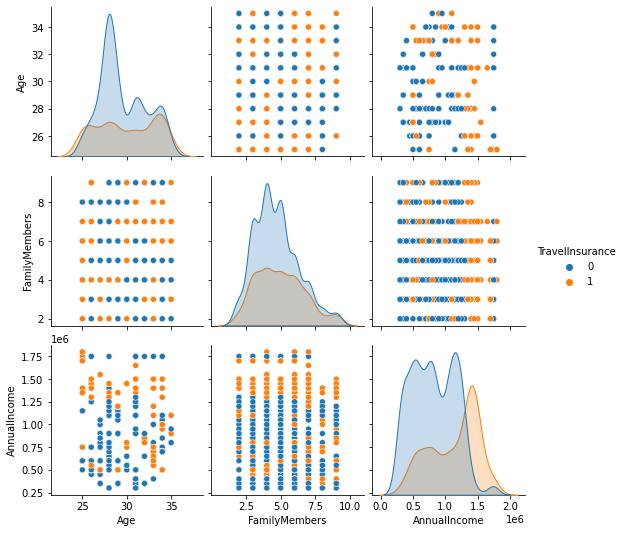

In [ ]:
seaborn.pairplot(
    train_df[["Age", "FamilyMembers", "AnnualIncome", "TravelInsurance"]], 
    hue="TravelInsurance"
)

- A primera vista la variable `AnnualIncome` parece influir fuertemente en la contratación del seguro.
- Se puede observar que aquellas personas que tienen un sueldo elevado, tienen menor cantidad de familiares.
- Parece verse que algunas personas más jóvenes (25 años) cobran sueldos muy altos, mientras que personas de mayor edad (35 años) no sobrepasan los 1.250.000 anual.

#### `Age`
Observamos la proporción de contratación de seguros por edad.

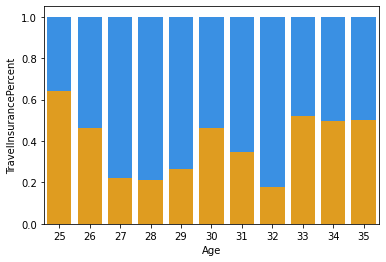

In [ ]:
age = train_df\
    .groupby('Age')['TravelInsurance']\
    .value_counts(normalize=True)\
    .rename('TravelInsurancePercent')\
    .reset_index()
age['total'] = 1
prop_plot(age, 'Age')

Se puede ver que los usuarios de los extremos tienden a contratar el seguro respecto al resto de las edades observadas. Pareciera ser una variable candidata para entrenar el modelo.

#### `FamilyMembers`
Representa la cantidad de familiares de la persona que contrata el seguro.

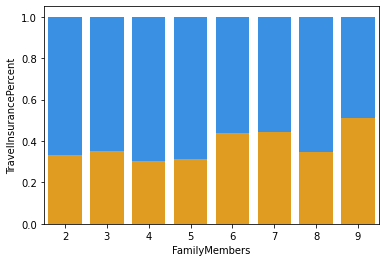

In [ ]:
FamilyMembers = train_df\
    .groupby('FamilyMembers')['TravelInsurance']\
    .value_counts(normalize=True)\
    .rename('TravelInsurancePercent')\
    .reset_index()
FamilyMembers['total'] = 1
prop_plot(FamilyMembers, 'FamilyMembers')

Se puede observar una leve tendencia a contratar el seguro según la cantidad de familiares.

#### `AnnualIncome`
Representa el ingreso anual del usuario.

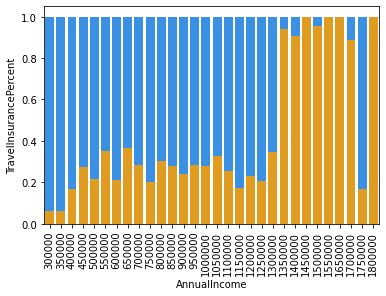

In [ ]:
AnnualIncome = train_df\
    .groupby('AnnualIncome')['TravelInsurance']\
    .value_counts(normalize=True)\
    .rename('TravelInsurancePercent')\
    .reset_index()
AnnualIncome['total'] = 1

plt.xticks(rotation=90)
prop_plot(AnnualIncome, 'AnnualIncome')

Vemos una relación muy marcada entre el ingreso del usuario y la contratación del seguro. Se observa un aumento considerable en la proporción cuando el salario anual supera los 130k.

### Análisis de variables categóricas
Analizamos la proporción de personas que contratan el seguro según las categorías definidas.

#### `GraduateOrNot`
Esta variable hacer referencia a si la persona se ha graduado o no de la universidad.

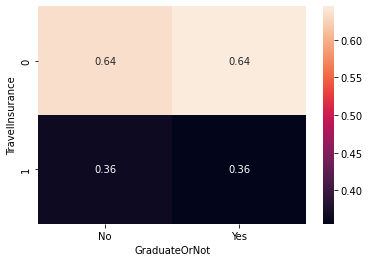

In [ ]:
seaborn.heatmap(
    pd.crosstab(
        train_df['TravelInsurance'], train_df["GraduateOrNot"], 
        normalize='columns'
    ), 
    annot=True
)

No vemos diferencias entre graduados y no graduados respecto a la contratación de seguros. Tantos en unos como otros, sólo el 36% de ellos, lo contratan. Sería una variable que podría no incluirse en el modelo.

#### `FrequentFlyer`
Esta variable nos indica si la persona viaja frecuentemente o no.

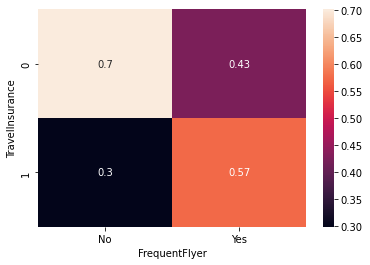

In [ ]:
seaborn.heatmap(
    pd.crosstab(
        train_df['TravelInsurance'], train_df["FrequentFlyer"], 
        normalize='columns'
    ), 
    annot=True
)

En el caso de esta variable, sí vemos cierta asociación. 
Entre los que viajan de forma frecuente, un 57% contratan seguro; mientras que dentro de los que no viajan de forma frecuente, sólo el 30% lo contratan. Esta variable consideramos que debemos incluirla en el modelo.

#### `EverTravelledAbroad`
Indica si la persona alguna vez ha viajado al exterior.

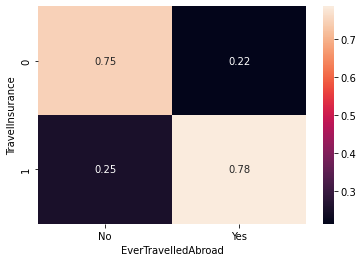

In [ ]:
seaborn.heatmap(
    pd.crosstab(
        train_df['TravelInsurance'], train_df["EverTravelledAbroad"],
        normalize='columns'
    ), 
    annot=True
)

De forma más marcada se ve relación entre la variable viaje al exterior y contratación de seguro. Debemos incluirla en el modelo.

#### `Employment Type`
Nos indica si la persona trabaja en el sector público o privado.

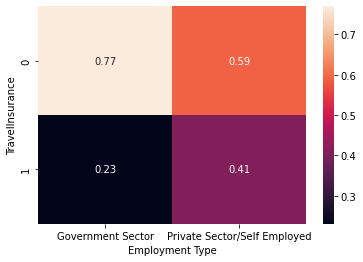

In [ ]:
seaborn.heatmap(
    pd.crosstab(
        train_df['TravelInsurance'], train_df["Employment Type"], 
        normalize='columns'
    ), 
    annot=True
)

Se puede observar que hay cierta influencia del tipo de empleo al momento de contratar un seguro o no. No hay evidente relacion entre las variables. Al tener variación deberíamos incluirla en el modelo.

#### `ChronicDiseases`
Esta variable indica si la persona actualmente padece de alguna enfermedad crónica.

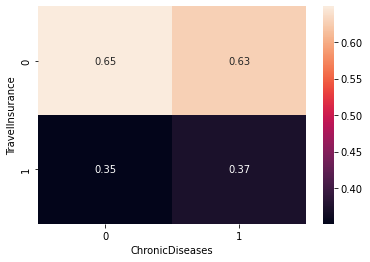

In [ ]:
seaborn.heatmap(
    pd.crosstab(
        train_df['TravelInsurance'], train_df["ChronicDiseases"], 
        normalize='columns'
    ), 
    annot=True
)

No se observa una relación directa con la contratación del seguro. No pareciera ser candidata a incluirla en el modelo. Ambos grupos se comportan de la misma manera.

## Feature Engineering

En esta etapa se realizaron las transformaciones necesarias para el entrenamiento. 

Si bien se probaron diferentes selecciones, extracciones y transformaciones, no se incluyeron muchas de éstas ya que no mejoraron los resultados.

### Separación del dataset
Antes de realizar la exploración de los datos, dividimos nuestro dataset en conjunto de train y conjunto de test. El conjunto de test provisto como dataset originalmente, sólo será utilizado para realizar la predicción final.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=["TravelInsurance"]), 
    train_df["TravelInsurance"], 
    test_size=0.3, 
    random_state=42, 
    stratify=train_df["TravelInsurance"]
)
X_train.shape, X_val.shape

((1043, 8), (447, 8))

Observamos si se respeta la proporción

In [ ]:
print("Proporción en datos de entrenamiento")
print(np.unique(y_train, return_counts=True))
print("")

print("Proporción en datos de validación")
print(np.unique(y_val, return_counts=True))

Proporción en datos de entrenamiento
(array([0, 1]), array([671, 372]))

Proporción en datos de validación
(array([0, 1]), array([287, 160]))


Las proporciones de 0 y 1 se siguen manteniendo en los nuevos conjuntos de train y val.

In [ ]:
# Veamos la varianza de los datos en cada conjunto, para ver si hace falta escalar
X_train.var(0)

Age                8.393647e+00
AnnualIncome       1.452038e+11
FamilyMembers      2.663719e+00
ChronicDiseases    2.000725e-01
dtype: float64

In [ ]:
# Veamos la varianza de los datos en cada conjunto, para ver si hace falta escalar
X_val.var(0)

Age                8.043228e+00
AnnualIncome       1.458188e+11
FamilyMembers      2.757707e+00
ChronicDiseases    1.998977e-01
dtype: float64

Vemos que hay baja varianza, tanto en datos de entrenamiento, como en datos de validación.

### Transformación de las columnas
Se probaron diferentes estrategias de transformación de los datos, se dejan aquellos que han dado mejores resultados.

#### Transformación baseline

In [ ]:
transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), ["Age", "AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

In [ ]:
X_train_t0 = transformer.fit_transform(X_train)
X_val_t0 = transformer.transform(X_val)
X_test_t0 = transformer.transform(test_df.drop(columns=["Customer"]))

#### Transformación 1
- Dejamos `Age` sin discretizar ya que los rangos de edades tanto en train como en test tienen poca varianza, van de 25 a 35.
- Dejamos `FamilyMembers` como está ya que en train y test tiene la misma distribución y tiene muy poca varianza con valores entre 2 y 9.
- Aumentamos la cantidad de bins de la discretización de `AnnualIncome` por presentar mayor varianza en el rango de datos.

In [ ]:
transformer1 = make_column_transformer(
    (KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile"), ["AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

In [ ]:
X_train_t1 = transformer1.fit_transform(X_train)
X_val_t1 = transformer1.transform(X_val)
X_test_t1 = transformer1.transform(test_df.drop(columns=["Customer"]))

#### Transformación 2

- Discretizamos todas las variables numéricas 
- La edad vemos que no tiene una relación lineal respecto al target, por lo tanto probamos discretizarla de manera no ordinal.

In [ ]:
transformer2 = make_column_transformer(
    (KBinsDiscretizer(n_bins=10, encode="onehot", strategy="quantile"), ["AnnualIncome"]),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"),
     ["Employment Type", "GraduateOrNot", "Age", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]),
    remainder="passthrough")

In [ ]:
X_train_t2 = transformer2.fit_transform(X_train)
X_val_t2 = transformer2.transform(X_val)
X_test_t2 = transformer2.transform(test_df.drop(columns=["Customer"]))

## Modelos

En esta etapa realizamos el entrenamiento y la evaluación de los datos utilizando diferentes modelos.

Primero observamos los resultados que se obtienen entrenando los tres conjuntos de datos transformados para cada modelo con parámetros por defecto como baseline.


 Modelos baseline

Decission Tree
T0: 0.6728775152800525 (0.05570303716071044)
T1: 0.6549665101120885 (0.0602325958192206)
T2: 0.6657988809208322 (0.07030931481970402)

XGBoost
T0: 0.7152246079014023 (0.0567981575660944)
T1: 0.7199663978868087 (0.061493800189002315)
T2: 0.6890918078316547 (0.05182967562560824)

LightGBM
T0: 0.6998859813831388 (0.050005592408774474)
T1: 0.7088646628938411 (0.05103451123134108)
T2: 0.6837353019081914 (0.047842231620918746)

Support Vector
T0: 0.6059128812418539 (0.045493740645545205)
T1: 0.6112370476355249 (0.05856231837449838)
T2: 0.6764318916358476 (0.05469748344299393)

KNeighbors
T0: 0.6599188071728553 (0.055812278103185446)
T1: 0.6729720335212868 (0.04987605886943303)
T2: 0.6567395724466308 (0.06314576703167779)

Gradient Boosting
T0: 0.7154576134880009 (0.0626391529121819)
T1: 0.7151584093650522 (0.06458587497089163)
T2: 0.6916201357230117 (0.06564325364173196)

Random Forest
T0: 0.6951020495608958 (0.04064045392552273)
T1: 0.6795891690009336 (0.04

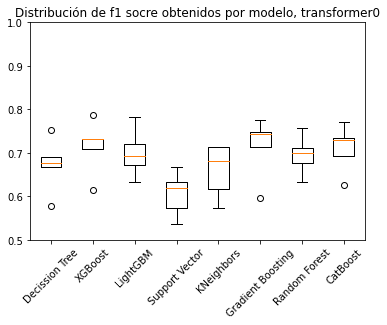

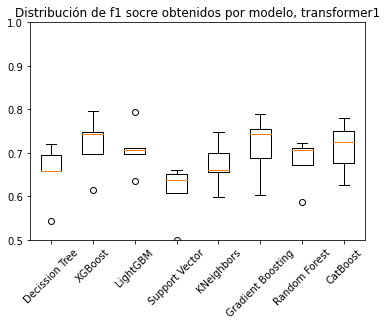

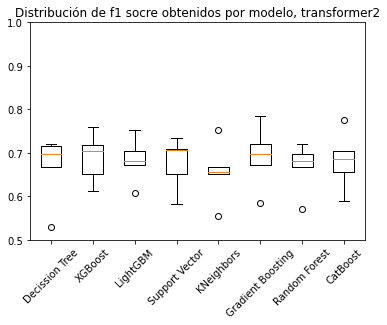

In [ ]:
print('==========================================')
print(' Modelos baseline')
print('==========================================')
results = {
    'transformer0': [],
    'transformer1': [],
    'transformer2': []
}
models = []
names = []

models.append(('Decission Tree', DecisionTreeClassifier()))
models.append(('XGBoost', XGBClassifier()))
models.append(('LightGBM', LGBMClassifier())) 
models.append(('Support Vector', SVC()))
models.append(('KNeighbors', KNeighborsClassifier())) 
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('CatBoost', CatBoostClassifier(verbose=0)))

for name, model in models:
    cv = StratifiedKFold()
        
    cv_results_t0 = cross_val_score(model, X_train_t0, y_train, cv=cv, scoring='f1')
    cv_results_t1 = cross_val_score(model, X_train_t1, y_train, cv=cv, scoring='f1')
    cv_results_t2 = cross_val_score(model, X_train_t2, y_train, cv=cv, scoring='f1')
    
    results['transformer0'].append(cv_results_t0) 
    results['transformer1'].append(cv_results_t1) 
    results['transformer2'].append(cv_results_t2) 
    names.append(name)

    print('')
    print(f'{name}')
    print('==========================================')
    print(f'T0: {cv_results_t0.mean()} ({cv_results_t0.std()})')
    print(f'T1: {cv_results_t1.mean()} ({cv_results_t1.std()})')
    print(f'T2: {cv_results_t2.mean()} ({cv_results_t2.std()})')

print('')
for i in range(3):
    plt.boxplot(results[f'transformer{i}'], labels=names)
    plt.title(f"Distribución de f1 socre obtenidos por modelo, transformer{i}")
    plt.xticks(rotation=45)
    plt.ylim(0.5, 1)
    plt.show() 
print('')

Algunos modelos funcionan mejor para cierto tipo de transformaciones. Por ejemplo, algunas predicen mejor si las features son categóricas, en otras, si las features son numéricas. En base a los resultados observados en los gráficos anteriores se utilizan los conjuntos de datos transformados sobre cada modelo según correspondan.

A continuación sólo se muestran aquellos modelos que mejores resultados dieron.

### Decision Tree Classifier

In [ ]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_t0, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
print("====================================================================")
print("DecissionTreeClassifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, tree_model.predict(X_train_t0)))

print("====================================================================")
print("DecissionTreeClassifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, tree_model.predict(X_val_t0)))

DecissionTreeClassifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       671
           1       0.97      0.77      0.86       372

    accuracy                           0.91      1043
   macro avg       0.93      0.88      0.90      1043
weighted avg       0.92      0.91      0.91      1043

DecissionTreeClassifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       287
           1       0.72      0.58      0.64       160

    accuracy                           0.77       447
   macro avg       0.76      0.73      0.74       447
weighted avg       0.76      0.77      0.76       447



#### Decision Tree Classifier con CrossValidation

In [ ]:
search_params = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [3, 6, 10]
}
tree = DecisionTreeClassifier(random_state=42)
tree_clf = GridSearchCV(tree, search_params, cv=5, scoring='f1', n_jobs=-1)
tree_clf.fit(X_train_t0, y_train)

best_tree_clf = tree_clf.best_estimator_
tree_clf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}

In [ ]:
print("====================================================================")
print("DecissionTreeClassifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, best_tree_clf.predict(X_train_t0)))

print("====================================================================")
print("DecissionTreeClassifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, best_tree_clf.predict(X_val_t0)))

DecissionTreeClassifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       671
           1       0.87      0.70      0.77       372

    accuracy                           0.86      1043
   macro avg       0.86      0.82      0.83      1043
weighted avg       0.86      0.86      0.85      1043

DecissionTreeClassifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       287
           1       0.73      0.61      0.67       160

    accuracy                           0.78       447
   macro avg       0.77      0.74      0.75       447
weighted avg       0.78      0.78      0.78       447



### XGBoost Classifier

In [ ]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train_t0, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [ ]:
print("====================================================================")
print("XGBoost Classifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, xgb_model.predict(X_train_t0)))

print("====================================================================")
print("XGBoost Classifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, xgb_model.predict(X_val_t0)))

XGBoost Classifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       671
           1       0.93      0.61      0.74       372

    accuracy                           0.84      1043
   macro avg       0.87      0.79      0.81      1043
weighted avg       0.86      0.84      0.84      1043

XGBoost Classifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       287
           1       0.83      0.57      0.68       160

    accuracy                           0.81       447
   macro avg       0.82      0.75      0.77       447
weighted avg       0.81      0.81      0.79       447



#### XGBoost Classifier con StandardScaler

In [ ]:
xgb_model_sc = make_pipeline(
    StandardScaler(with_mean=False), 
    XGBClassifier(eval_metric='logloss', use_label_encoder=False)
)
xgb_model_sc.fit(X_train_t0, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, learning_rate=0.1, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               use_label_encoder=False, verbosity=1))],
         verbose=False)

In [ ]:
print("====================================================================")
print("XGBoost Classifier con Std Scaler - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, xgb_model_sc.predict(X_train_t0)))

print("====================================================================")
print("XGBoost Classifier con Std Scaler - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, xgb_model_sc.predict(X_val_t0)))

XGBoost Classifier con Std Scaler - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       671
           1       0.93      0.61      0.74       372

    accuracy                           0.84      1043
   macro avg       0.87      0.79      0.81      1043
weighted avg       0.86      0.84      0.84      1043

XGBoost Classifier con Std Scaler - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       287
           1       0.83      0.57      0.68       160

    accuracy                           0.81       447
   macro avg       0.82      0.75      0.77       447
weighted avg       0.81      0.81      0.79       447



#### XGBoost con CrossValidation

In [ ]:
param_grid = {
    "learning_rate"    : [0.10, 0.20, 0.30] ,
    "max_depth"        : [ 3, 6, 10],
    "min_child_weight" : [ 1, 3],
    "gamma"            : [ 0.0, 0.1, 0.2 ],
    "colsample_bytree" : [ 0.3, 0.5 , 0.7],
    'subsample': [0.6, 0.8, 1.0],
    'alpha': (0.1, 10)
}

xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, objective='binary:logistic')
xgb_clf = GridSearchCV(xgb, param_grid, scoring='f1', n_jobs=-1, cv=3)
xgb_clf.fit(X_train_t0, y_train)
best_xgb_clf = xgb_clf.best_estimator_
xgb_clf.best_params_

{'alpha': 0.1,
 'colsample_bytree': 0.5,
 'gamma': 0.2,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 1.0}

In [ ]:
print("====================================================================")
print("XGBoost Classifier con CV - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, best_xgb_clf.predict(X_train_t0)))

print("====================================================================")
print("XGBoost Classifier con CV - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, best_xgb_clf.predict(X_val_t0)))

XGBoost Classifier con CV - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       671
           1       0.91      0.65      0.76       372

    accuracy                           0.85      1043
   macro avg       0.87      0.81      0.83      1043
weighted avg       0.86      0.85      0.85      1043

XGBoost Classifier con CV - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       287
           1       0.81      0.61      0.69       160

    accuracy                           0.81       447
   macro avg       0.81      0.76      0.78       447
weighted avg       0.81      0.81      0.80       447



### LigthGBM Classifier

In [ ]:
lgbm_model = LGBMClassifier(is_unbalance=True)
lgbm_model.fit(X_train_t0, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
print("====================================================================")
print("LightGBM Classifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, lgbm_model.predict(X_train_t0)))

print("====================================================================")
print("LightGBM Classifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, lgbm_model.predict(X_val_t0)))

LightGBM Classifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       671
           1       0.86      0.81      0.83       372

    accuracy                           0.89      1043
   macro avg       0.88      0.87      0.87      1043
weighted avg       0.89      0.89      0.88      1043

LightGBM Classifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       287
           1       0.64      0.61      0.63       160

    accuracy                           0.74       447
   macro avg       0.72      0.71      0.71       447
weighted avg       0.74      0.74      0.74       447



### Support Vector Classifier

#### Support Vector Classifier con StandarScaler

In [ ]:
svc_model = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
svc_model.fit(X_train_t0, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
print("====================================================================")
print("SVC Classifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, svc_model.predict(X_train_t0)))

print("====================================================================")
print("SVC Classifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, svc_model.predict(X_val_t0)))

SVC Classifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       671
           1       0.89      0.62      0.73       372

    accuracy                           0.84      1043
   macro avg       0.85      0.79      0.80      1043
weighted avg       0.84      0.84      0.83      1043

SVC Classifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       287
           1       0.79      0.55      0.65       160

    accuracy                           0.79       447
   macro avg       0.79      0.73      0.75       447
weighted avg       0.79      0.79      0.77       447



### KNeighbors Classifier

#### KNeighbors Classifier con StandarScaler

In [ ]:
KNN_model = make_pipeline(
    StandardScaler(with_mean=False), 
    KNeighborsClassifier(n_neighbors=3)
)
KNN_model.fit(X_train_t0, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
print("====================================================================")
print("KNeighbors Classifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, KNN_model.predict(X_train_t0)))

print("====================================================================")
print("KNeighbors Classifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, KNN_model.predict(X_val_t0)))

KNeighbors Classifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       671
           1       0.87      0.67      0.76       372

    accuracy                           0.85      1043
   macro avg       0.85      0.81      0.82      1043
weighted avg       0.85      0.85      0.84      1043

KNeighbors Classifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       287
           1       0.67      0.50      0.57       160

    accuracy                           0.73       447
   macro avg       0.71      0.68      0.69       447
weighted avg       0.73      0.73      0.72       447



### Gradient Boosting Classifier

#### Gradient Boosting Classifier con StandarScaler

In [ ]:
gbc_model = make_pipeline(
    StandardScaler(with_mean=False), 
    GradientBoostingClassifier(n_estimators=30, learning_rate=0.25)
)
gbc_model.fit(X_train_t0, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.25, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=30,
                                            n_iter_no

In [ ]:
print("====================================================================")
print("Gradient Boosting Classifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, gbc_model.predict(X_train_t0)))

print("====================================================================")
print("Gradient Boosting Classifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, gbc_model.predict(X_val_t0)))

Gradient Boosting Classifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       671
           1       0.93      0.62      0.74       372

    accuracy                           0.85      1043
   macro avg       0.88      0.80      0.82      1043
weighted avg       0.86      0.85      0.84      1043

Gradient Boosting Classifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       287
           1       0.82      0.58      0.68       160

    accuracy                           0.81       447
   macro avg       0.81      0.76      0.77       447
weighted avg       0.81      0.81      0.80       447



### Random Forest Classifier

#### Random Forest Classifier con StandarScaler

In [ ]:
rf_model = make_pipeline(
    StandardScaler(with_mean=False), 
    RandomForestClassifier(n_estimators=100, random_state=0)
)
rf_model.fit(X_train_t0, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=Fal

In [ ]:
print("====================================================================")
print("Random Forest Classifier - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, rf_model.predict(X_train_t0)))

print("====================================================================")
print("Random Forest Classifier - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, rf_model.predict(X_val_t0)))

Random Forest Classifier - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       671
           1       0.94      0.80      0.87       372

    accuracy                           0.91      1043
   macro avg       0.92      0.89      0.90      1043
weighted avg       0.91      0.91      0.91      1043

Random Forest Classifier - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       287
           1       0.72      0.61      0.66       160

    accuracy                           0.77       447
   macro avg       0.76      0.74      0.75       447
weighted avg       0.77      0.77      0.77       447



#### Random Forest con Cross Validation

In [ ]:
param_grid = {
    'n_estimators': [150],
    'max_features': [5, 7, 9],
    'max_depth'   : [None, 3, 10, 20],
    'criterion'   : ['gini', 'entropy']
}

# Grid Search CV implementation
rf = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123)
rf_clf = GridSearchCV(rf, param_grid, scoring='f1', n_jobs=-1, cv=3)
rf_clf.fit(X_train_t0, y_train)
best_rf_clf = rf_clf.best_estimator_
best_rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features=9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=123, verbose=0,
                       warm_start=False)

In [ ]:
print("====================================================================")
print("Random Forest Classifier con CV - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, best_rf_clf.predict(X_train_t0)))

print("====================================================================")
print("Random Forest Classifier con CV - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, best_rf_clf.predict(X_val_t0)))

Random Forest Classifier con CV - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       671
           1       0.96      0.69      0.80       372

    accuracy                           0.88      1043
   macro avg       0.90      0.84      0.86      1043
weighted avg       0.89      0.88      0.87      1043

Random Forest Classifier con CV - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       287
           1       0.78      0.59      0.67       160

    accuracy                           0.79       447
   macro avg       0.79      0.75      0.76       447
weighted avg       0.79      0.79      0.79       447



### Cat Boost Classifier

#### CatBoost Classifier con StandarScaler

In [ ]:
cb_model = make_pipeline(
    StandardScaler(with_mean=False), 
    #CatBoostClassifier(iterations=2, learning_rate=1, depth=2)
    CatBoostClassifier(verbose=0)
)
cb_model.fit(X_train_t2, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f41cd27dc50>)],
         verbose=False)

In [ ]:
print("====================================================================")
print("CatBoost Classifier con StandarScaler - Reporte de clasificación de train")
print("====================================================================")
print(classification_report(y_train, cb_model.predict(X_train_t2)))

print("====================================================================")
print("CatBoost Classifier con StandarScaler - Reporte de clasificación de val")
print("====================================================================")
print(classification_report(y_val, cb_model.predict(X_val_t2)))

CatBoost Classifier con StandarScaler - Reporte de clasificación de train
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       671
           1       0.96      0.71      0.82       372

    accuracy                           0.89      1043
   macro avg       0.91      0.85      0.87      1043
weighted avg       0.89      0.89      0.88      1043

CatBoost Classifier con StandarScaler - Reporte de clasificación de val
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       287
           1       0.78      0.57      0.66       160

    accuracy                           0.79       447
   macro avg       0.79      0.74      0.75       447
weighted avg       0.79      0.79      0.78       447



## Predicciones sobre el conjunto de test

Generamos el archivo csv para ser enviado a la competencia.

In [ ]:
test_id = test_df["Customer"]
columns = ["Customer", "TravelInsurance"]

**XGBoost**

In [ ]:
test_pred = xgb_model.predict(X_test_t0)
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=columns)
submission.to_csv('travel_insurance_submission.csv', header=True, index=False)
files.download('travel_insurance_submission.csv')

**LightGBM**

In [ ]:
test_pred2 = lgbm_model.predict(X_test_t0)
submission2 = pd.DataFrame(list(zip(test_id, test_pred2)), columns=columns)
submission2.to_csv('travel_insurance_submission2.csv', header=True, index=False)
files.download('travel_insurance_submission2.csv')

**Gradient Boosting**

In [ ]:
test_pred3 = gbc_model.predict(X_test_t0)
submission3 = pd.DataFrame(list(zip(test_id, test_pred3)), columns=columns)
submission3.to_csv('travel_insurance_submission3.csv', header=True, index=False)
files.download('travel_insurance_submission3.csv')

**Random Forest**

In [ ]:
test_pred4 = rf_model.predict(X_test_t0)
submission4 = pd.DataFrame(list(zip(test_id, test_pred4)), columns=columns)
submission4.to_csv('travel_insurance_submission4.csv', header=True, index=False)
files.download('travel_insurance_submission4.csv')

**Random Forest CV**

In [ ]:
test_pred5 = best_rf_clf.predict(X_test_t0)
submission5 = pd.DataFrame(list(zip(test_id, test_pred5)), columns=columns)
submission5.to_csv('travel_insurance_submission5.csv', header=True, index=False)
# Es el mejor modelo hasta ahora, F1 de test: 0.80898
files.download('travel_insurance_submission5.csv') 

**Cat Boost**



In [ ]:
test_pred6 = cb_model.predict(X_test_t2)
submission6 = pd.DataFrame(list(zip(test_id, test_pred6)), columns=columns)
submission6.to_csv('travel_insurance_submission6.csv', header=True, index=False)
files.download('travel_insurance_submission6.csv') 

## Conclusiones

Si bien se probaron diferentes técnicas tanto de ingeniería de datos así como también distintos modelos, no se lograron resultados muy buenos. En algunos casos el modelo parece hacer _overfitting_ sobre el conjunto de entrenamiento.

Los modelos con mejores f1-score en la competencia Kaggle fueron:
- **Random Forest** con CV: 0.80898
- **XGBoost**, y **Gradient Boosting**: 0,79545 (mismo score ambos)